# Import

In [ ]:
import os
import shutil
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image

# Setting directory paths

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
base_dir = r"gdrive/MyDrive/Road/"

In [ ]:
train_dir = os.path.join(base_dir,'train')
test_dir = os.path.join(base_dir,'test')
validation_dir = os.path.join(base_dir,'validation')

In [ ]:
train_plain_dir = r"gdrive/MyDrive/Road/train/plain/"
train_pothole_dir = r"gdrive/MyDrive/Road/train/pothole/"

In [ ]:
test_plain_dir = r"gdrive/MyDrive/Road/test/plain/"
test_pothole_dir = r"gdrive/MyDrive/Road/test/pothole"

In [ ]:
validation_plain_dir = r"gdrive/MyDrive/Road/validation/plain"
validation_pothole_dir = r"gdrive/MyDrive/Road/validation/pothole"

In [ ]:
print('total training plain images :', len(os.listdir(train_plain_dir)))
print('total training pothole images : ',len(os.listdir(train_pothole_dir)))
print('total test plain images :', len(os.listdir(test_plain_dir)))
print('total test pothole images :', len(os.listdir(test_pothole_dir)))
print('total validation plain images :', len(os.listdir(validation_plain_dir)))
print('total validation pothole images :', len(os.listdir(validation_pothole_dir)))

total training plain images : 202
total training pothole images :  170
total test plain images : 166
total test pothole images : 156
total validation plain images : 84
total validation pothole images : 84


# Re-scaling images to 224 X 224 to match VGG16 input size

In [ ]:
train_size = len(os.listdir(train_plain_dir))+len(os.listdir(train_pothole_dir))
test_size = len(os.listdir(test_plain_dir))+len(os.listdir(test_pothole_dir))
validation_size = len(os.listdir(validation_plain_dir)) + len(os.listdir(validation_pothole_dir))
img_width, img_height = 224, 224
print(train_size)
print(test_size)
print(validation_size)

372
322
168


In [ ]:
def show_pictures(path):
    random_img = random.choice(os.listdir(path))
    img_path = os.path.join(path, random_img)
    print(random_img)
    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
    img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application
    plt.imshow(img_tensor)
    plt.show()

images - 2022-08-26T001109.234.jpg


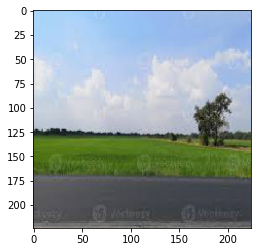

264.4342_001-potholes.JPG


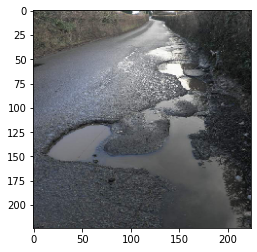

download (6).jpg


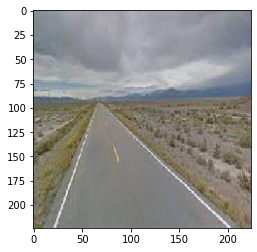

222.fdf31365-9596-4fb4-a244-b1dc7d9c46a0-pothole.jpg


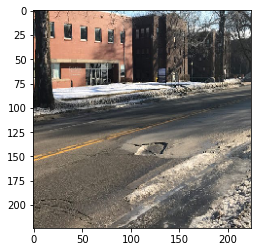

In [ ]:
for i in range(0,2):
    show_pictures(train_plain_dir)
    show_pictures(train_pothole_dir)

# Obtaining the pre-trained weights from VGG16 for the Convolutional Base

In [ ]:
from keras.applications import vgg16

# Input Shape: (224 X 224 X 3) where 3 is the number of input color channels, RGB
conv_base = vgg16.VGG16(weights='imagenet', 
                  include_top=False,
                  input_shape=(img_width, img_height, 3))

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# Loading Dataset


In [ ]:
# Extract features

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))  # Must be equal to the output of the convolutional base
    labels = np.zeros(shape=(sample_count))
    # Preprocess data
    generator = datagen.flow_from_directory(directory,
                                            target_size=(img_width,img_height),
                                            batch_size = batch_size,
                                            class_mode='binary')
    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
    

In [ ]:
train_features, train_labels = extract_features(train_dir, train_size)  # Agree with our small dataset size
validation_features, validation_labels = extract_features(validation_dir, validation_size)
test_features, test_labels = extract_features(test_dir,test_size)

Found 372 images belonging to 2 classes.
Found 168 images belonging to 2 classes.
Found 321 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
# Debug
print(train_features)
print(train_labels)

[[[[1.31456649e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    3.51054728e-01 0.00000000e+00]
   [9.35748935e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   [2.16071129e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    2.70251423e-01 0.00000000e+00]
   ...
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    3.63417804e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    6.93294883e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 2.51197219e-02 ... 0.00000000e+00
    8.28016758e-01 0.00000000e+00]]

  [[2.43906975e+00 0.00000000e+00 5.06550372e-01 ... 0.00000000e+00
    5.15173852e-01 0.00000000e+00]
   [2.17082572e+00 0.00000000e+00 6.44304693e-01 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   [1.39375418e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    1.74007505e-01 0.00000000e+00]
   ...
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00

In [ ]:
train_features.shape

(372, 7, 7, 512)

# Fully Connected Layer Model

In [ ]:
# Define model
from keras import models
from keras import layers
from keras import optimizers

epochs = 100

model = models.Sequential()
model.add(layers.Flatten(input_shape=(7,7,512)))
model.add(layers.Dense(256, activation='relu', input_dim=(7*7*512)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 6,423,041
Trainable params: 6,423,041
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile model
import tensorflow as tf 

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])

In [ ]:
# Train model
history = model.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size, 
                    validation_data=(validation_features, validation_labels))

Epoch 1/100
7/7 [==============================] - 2s 105ms/step - loss: 1.8380 - acc: 0.6335 - val_loss: 0.2025 - val_acc: 0.9107
Epoch 2/100
7/7 [==============================] - 0s 73ms/step - loss: 0.2101 - acc: 0.9050 - val_loss: 0.1163 - val_acc: 0.9524
Epoch 3/100
7/7 [==============================] - 0s 73ms/step - loss: 0.1440 - acc: 0.9548 - val_loss: 0.0970 - val_acc: 0.9583
Epoch 4/100
7/7 [==============================] - 0s 72ms/step - loss: 0.0768 - acc: 0.9729 - val_loss: 0.0838 - val_acc: 0.9702
Epoch 5/100
7/7 [==============================] - 0s 72ms/step - loss: 0.0428 - acc: 0.9819 - val_loss: 0.0716 - val_acc: 0.9702
Epoch 6/100
7/7 [==============================] - 0s 71ms/step - loss: 0.0199 - acc: 1.0000 - val_loss: 0.0752 - val_acc: 0.9762
Epoch 7/100
7/7 [==============================] - 1s 75ms/step - loss: 0.0156 - acc: 1.0000 - val_loss: 0.0671 - val_acc: 0.9702
Epoch 8/100
7/7 [==============================] - 0s 73ms/step - loss: 0.0173 - acc: 0.9

In [ ]:
# Save model
model.save('pothole_fcl.h5')

In [ ]:
from tensorflow import keras
# Load model
model = keras.models.load_model('pothole_fcl.h5')

# Fully Connected Layer Model Evaluation

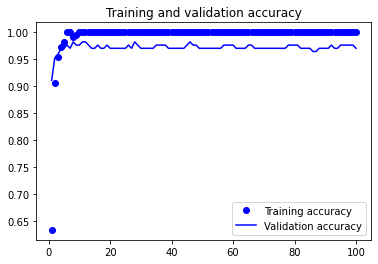

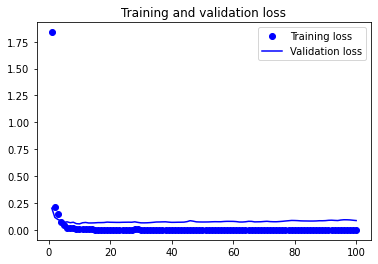

In [ ]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Fully Connected Layer Model in Action

In [ ]:
# Define function to visualize predictions
def visualize_predictions(classifier, n_cases):
    for i in range(0,n_cases):
        path = random.choice([test_plain_dir, test_pothole_dir])

        # Get picture
        random_img = random.choice(os.listdir(path))
        img_path = os.path.join(path, random_img)
        img = image.load_img(img_path, target_size=(img_width, img_height))
        img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
        img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application

        # Extract features
        features = conv_base.predict(img_tensor.reshape(1,img_width, img_height, 3))

        # Make prediction
        try:
            prediction = classifier.predict(features)
        except:
            prediction = classifier.predict(features.reshape(1, 7*7*512))

        # Show picture
        plt.imshow(img_tensor)
        plt.show()

        # Write prediction
        if prediction < 0.5:
            print('Plain')
        else:
            print('Pothole')

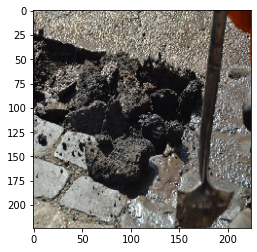

Pothole


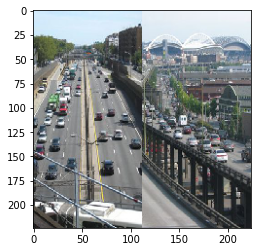

Plain


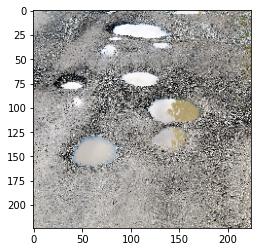

Pothole


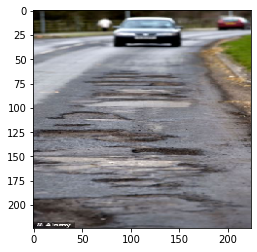

Pothole


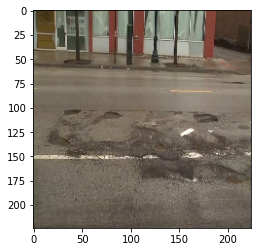

Pothole


In [ ]:
# Visualize predictions
visualize_predictions(model, 5)

# Fully Connected Layer Model Performance Metrics

In [ ]:
# Define function to visualize predictions
def test_output(classifier):
    result = []
    for f in test_features:
      try:
          prediction = classifier.predict(f)
      except:
          prediction = classifier.predict(f.reshape(1, 7, 7, 512))
      if(prediction < 0.5):
        result.append(0)
      else:
        result.append(1)
        
    return result
o = test_output(model)

Confusion Matrix: 
[[150  15]
 [  6 151]]
Accuracy:  0.9347826086956522
Specificity:  0.9090909090909091
Precision/Positive Predictive Value:  0.9096385542168675
Negative Predictive Value:  0.9615384615384616
Recall/Sensitivity:  0.9617834394904459
False Positive Rate:  0.7142857142857143
False Negative Rate:  0.03821656050955414
Positive Likelihood Ratio:  1.3464968152866241
Negative Likelihod Ratio:  0.04203821656050955
Diagnostic Odds Ratio:  32.03030303030303
False Omission Rate:  0.038461538461538464
F1 Score:  0.934984520123839
Area under ROC curve:  0.9354371742906775


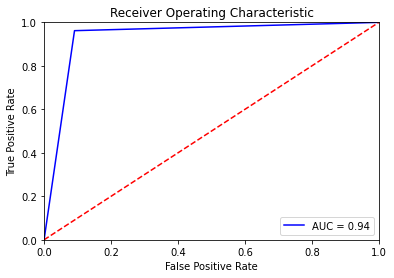

In [ ]:
from sklearn.metrics import *
matrix = confusion_matrix(test_labels, o)
print("Confusion Matrix: ")
print(matrix)
[[tn, fp], [fn, tp]] = matrix

acc_score = accuracy_score(test_labels, o)
precision = precision_score(test_labels, o)
recall = tpr = recall_score(test_labels, o)
f1 = f1_score(test_labels, o)
roc_score = roc_auc_score(test_labels, o)
spc = tnr = tn/(tn + fp)
fpr = fp/(fp + fn)
fnr = fn/(fn+tp)
plr = tpr/fpr
nlr = fnr/tnr
dor = plr/nlr
npv = tn/(fn+tn)
fr = fn/(fn+tn)

print("Accuracy: ", acc_score)
print("Specificity: ", spc)
print("Precision/Positive Predictive Value: ", precision)
print("Negative Predictive Value: ", npv)
print("Recall/Sensitivity: ", recall)
print("False Positive Rate: ", fpr)
print("False Negative Rate: ", fnr)
print("Positive Likelihood Ratio: ", plr)
print("Negative Likelihod Ratio: ", nlr)
print("Diagnostic Odds Ratio: ", dor)
print("False Omission Rate: ", fr)
print("F1 Score: ", f1)
print("Area under ROC curve: ", roc_score)


fpr, tpr, threshold = roc_curve(test_labels, o)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Classifier2: Global Average Pooling Model


In [ ]:
# Define model
from keras import models
from keras import layers
from keras import optimizers

epochs = 100

model = models.Sequential()
model.add(layers.GlobalAveragePooling2D(input_shape=(7,7,512)))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 1)                 513       
                                                                 
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile model
import tensorflow as tf 

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])

In [ ]:
# Train model
history = model.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size, 
                    validation_data=(validation_features, validation_labels))

Epoch 1/100
7/7 [==============================] - 1s 100ms/step - loss: 0.7752 - acc: 0.4977 - val_loss: 0.7412 - val_acc: 0.4940
Epoch 2/100
7/7 [==============================] - 0s 12ms/step - loss: 0.7221 - acc: 0.4932 - val_loss: 0.7079 - val_acc: 0.4702
Epoch 3/100
7/7 [==============================] - 0s 11ms/step - loss: 0.6934 - acc: 0.4932 - val_loss: 0.6882 - val_acc: 0.5417
Epoch 4/100
7/7 [==============================] - 0s 14ms/step - loss: 0.6759 - acc: 0.6109 - val_loss: 0.6707 - val_acc: 0.6607
Epoch 5/100
7/7 [==============================] - 0s 12ms/step - loss: 0.6594 - acc: 0.7466 - val_loss: 0.6524 - val_acc: 0.7440
Epoch 6/100
7/7 [==============================] - 0s 13ms/step - loss: 0.6432 - acc: 0.7828 - val_loss: 0.6334 - val_acc: 0.7976
Epoch 7/100
7/7 [==============================] - 0s 12ms/step - loss: 0.6252 - acc: 0.8371 - val_loss: 0.6165 - val_acc: 0.8690
Epoch 8/100
7/7 [==============================] - 0s 12ms/step - loss: 0.6095 - acc: 0.8

In [ ]:
# Save model
model.save('pothole_gap.h5')

In [ ]:
from tensorflow import keras
# Load model
model2 = keras.models.load_model('pothole_gap.h5')

#  Classifier 2: Global Average Pooling Model Evaluation

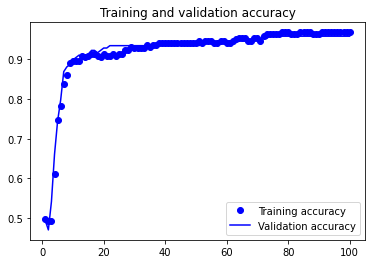

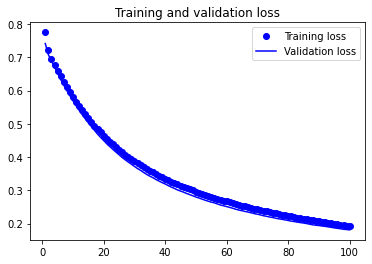

In [ ]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#Classifier 2: Global Average Pooling Model in Action

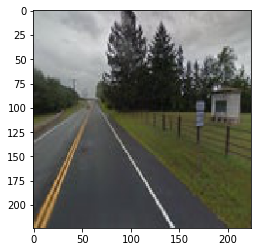

Plain


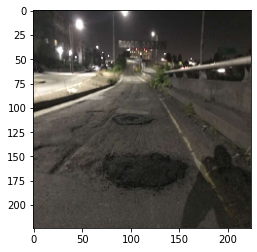

Plain


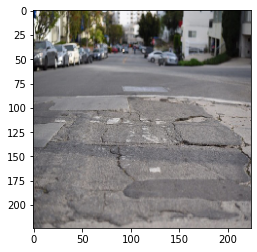

Pothole


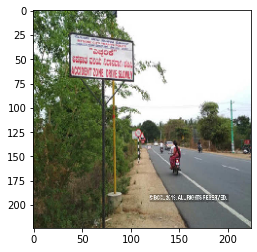

Plain


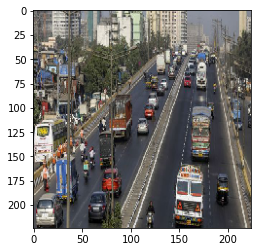

Plain


In [ ]:
# Visualize predictions
visualize_predictions(model, 5)

# Classifier2: Global Average Pooling Model Performance Metrics

In [ ]:
# Define function to visualize predictions
def test_output(classifier):
    result = []
    for f in test_features:
      try:
          prediction = classifier.predict(f)
      except:
          prediction = classifier.predict(f.reshape(1, 7, 7, 512))
      if(prediction < 0.5):
        result.append(0)
      else:
        result.append(1)
        
    return result
o = test_output(model)

Confusion Matrix: 
[[145  20]
 [  8 149]]
Accuracy:  0.9130434782608695
Specificity:  0.8787878787878788
Precision/Positive Predictive Value:  0.8816568047337278
Negative Predictive Value:  0.9477124183006536
Recall/Sensitivity:  0.9490445859872612
False Positive Rate:  0.7142857142857143
False Negative Rate:  0.050955414012738856
Positive Likelihood Ratio:  1.3286624203821655
Negative Likelihod Ratio:  0.057983746980013184
Diagnostic Odds Ratio:  22.914393939393936
False Omission Rate:  0.05228758169934641
F1 Score:  0.9141104294478528
Area under ROC curve:  0.91391623238757


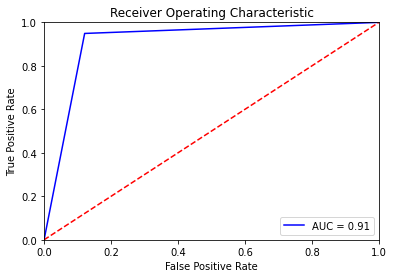

In [ ]:
from sklearn.metrics import *
matrix = confusion_matrix(test_labels, o)
print("Confusion Matrix: ")
print(matrix)
[[tn, fp], [fn, tp]] = matrix

acc_score = accuracy_score(test_labels, o)
precision = precision_score(test_labels, o)
recall = tpr = recall_score(test_labels, o)
f1 = f1_score(test_labels, o)
roc_score = roc_auc_score(test_labels, o)
spc = tnr = tn/(tn + fp)
fpr = fp/(fp + fn)
fnr = fn/(fn+tp)
plr = tpr/fpr
nlr = fnr/tnr
dor = plr/nlr
npv = tn/(fn+tn)
fr = fn/(fn+tn)

print("Accuracy: ", acc_score)
print("Specificity: ", spc)
print("Precision/Positive Predictive Value: ", precision)
print("Negative Predictive Value: ", npv)
print("Recall/Sensitivity: ", recall)
print("False Positive Rate: ", fpr)
print("False Negative Rate: ", fnr)
print("Positive Likelihood Ratio: ", plr)
print("Negative Likelihod Ratio: ", nlr)
print("Diagnostic Odds Ratio: ", dor)
print("False Omission Rate: ", fr)
print("F1 Score: ", f1)
print("Area under ROC curve: ", roc_score)


fpr, tpr, threshold = roc_curve(test_labels, o)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()